In this notebook, I show an example of training a template on a simulated data set. I manually iterate the perturbations so I can save multiple steps along the way to show the progession.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random, copy

from modules import get_bandpass_dict, get_eff_wavelen, Sed, perturb_template

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the blue-est of the CWW+SB4 templates:

In [3]:
name = 'templates/ssp_5Myr_z008.sed'
x,y = np.loadtxt(name,unpack=True)
sed = Sed()
sed.wavelen = x
sed.flambda = y
del x,y

Load the filters

In [27]:
bandpass_dict = get_bandpass_dict()

# use only the LSST filters
bandpass_dict = {'u' : bandpass_dict['u'],
                 'g' : bandpass_dict['g'],
                 'r' : bandpass_dict['r'],
                 'i' : bandpass_dict['i'],
                 'z' : bandpass_dict['z'],
                 'y' : bandpass_dict['y']}

Create a set of redshifted photometry

In [30]:
photometry = []
filters = list(bandpass_dict.keys())
random.seed(11)
for i in range(1000):
    sed_ = copy.deepcopy(sed)
    redshift = np.random.rand()*3
    sed_.redshift(redshift)
    eff_wavelen = get_eff_wavelen(bandpass_dict)
    wavelen = eff_wavelen/(1+redshift)
    
    fluxes = sed_.fluxlist(bandpass_dict)
    fluxes = [random.gauss(i,0.1*i) for i in fluxes]
    
    for i in range(len(wavelen)):
        photometry.append([wavelen[i],fluxes[i],0.1*fluxes[i],redshift,filters[i]])

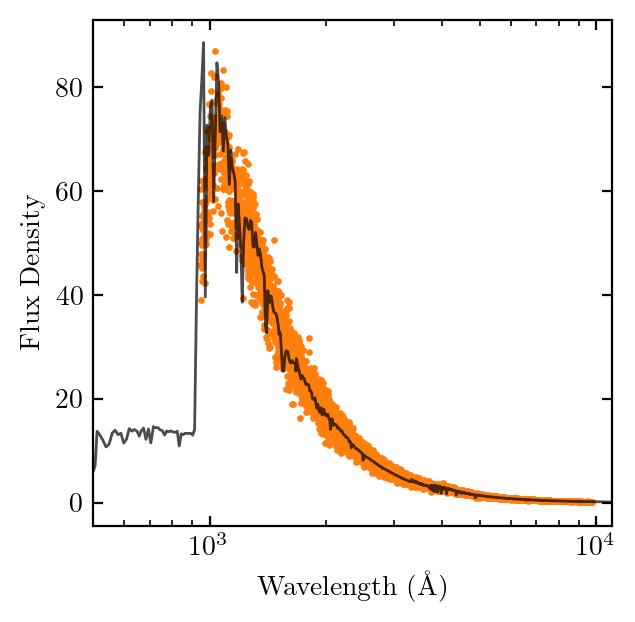

In [31]:
# plot photometry
wavelen = [i[0] for i in photometry]
flux  = [i[1] for i in photometry]
plt.scatter(wavelen,flux,c='C1',s=2)

# plot original template
plt.plot(sed.wavelen,sed.flambda,c='k',lw=1,alpha=0.7)

plt.xlim(500,11000)
plt.xlabel("Wavelength ($\mathrm{\AA}$)")
plt.ylabel("Flux Density")
plt.xscale('log')
plt.show()

Create a naive template

In [32]:
template = Sed()
template.wavelen = np.linspace(100,13000,500)
template.flambda = 0*template.wavelen

And perturb it 100 times

In [33]:
%%time
history = dict()
save = [1,5,50,100]
new_template = copy.deepcopy(template)
for i in range(100):
    sol = perturb_template(new_template,photometry,bandpass_dict,w=10)
    new_template.flambda += sol
    if i + 1 in save:
        history[i+1] = copy.deepcopy(new_template)

CPU times: user 21min 25s, sys: 15.4 s, total: 21min 41s
Wall time: 5min 25s


Plot the results!

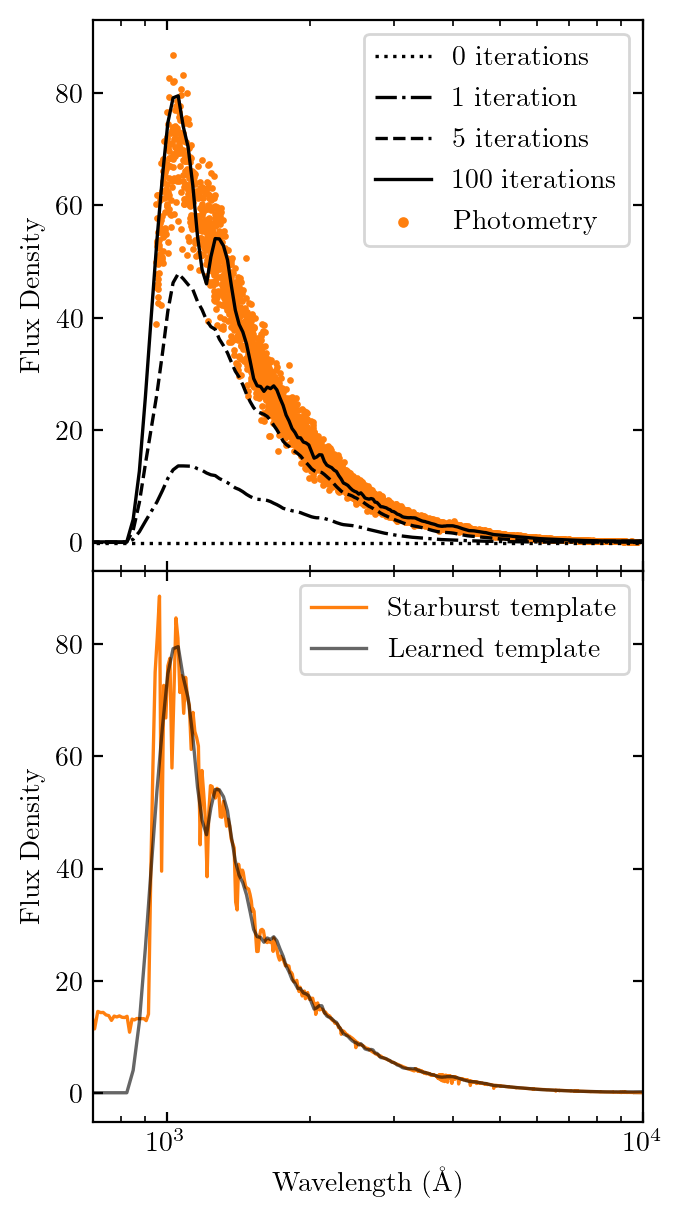

In [49]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex='all',sharey='all',figsize=(onecol,1.8*onecol))

# plot the photometry
wavelen = [i[0] for i in photometry]
flux  = [i[1] for i in photometry]
ax1.scatter(wavelen,flux,c='C1',s=2)

# plot different stages of training
ax1.plot(template.wavelen,template.flambda,label='0 iterations',c='k',ls=':')
ax1.plot(history[1].wavelen,history[1].flambda,label='1 iteration',c='k',ls='-.')
ax1.plot(history[5].wavelen,history[5].flambda,label='5 iterations',c='k',ls='--')
ax1.plot(history[100].wavelen,history[100].flambda,label='100 iterations',c='k',ls='-')
ax1.scatter(-10,-10,c='C1',s=8,label='Photometry')
ax1.legend()

# plot learned template with the original template
ax2.plot(sed.wavelen,sed.flambda,c='C1',label='Starburst template')
ax2.plot(history[100].wavelen,history[100].flambda,c='k',alpha=0.6,label='Learned template')
ax2.legend()

# axes
ax1.set_xlim(700,10000)
ax1.set_ylim(-5,93)
ax2.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylabel("Flux Density")
ax2.set_ylabel("Flux Density")
ax1.set_xscale('log')

plt.tight_layout(pad=0.5,h_pad=0)
fig.savefig('plots/training_example.pdf')